In [58]:
import numpy as np
import pandas as pd
import csv

import networkx as nx
import os
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [59]:
def read_eeg_data(directory):

    eeg_data = {}
    file_names = os.listdir(directory)

    for file_name in file_names:
        if file_name.endswith('.mat'):  
            file_path = os.path.join(directory, file_name)

            # Load data from .mat files
            data = loadmat(file_path)  
            for key, value in data.items(): 
                if key.startswith('v') and isinstance(value, np.ndarray):  # extract eeg data of each subject
                    eeg_data[key] = value 
                    
    return eeg_data

In [60]:
eeg_directory = r"D:\sanjay\sem 6\ADHD\Control_part2"
    
eeg_data = read_eeg_data(eeg_directory)
eeg_data

{'v117': array([[ 191,  156,   16, ...,  -55,  156,  -90],
        [ 261,  297, -351, ...,  332,  191,  332],
        [ 191,   85, -388, ...,  -19,   15,   85],
        ...,
        [ 578,  613,  641, ...,  649,  684,  649],
        [ 508,  543,  494, ...,  261,  332,   15],
        [ 156,  297,  273, ...,  261,  508,  543]], dtype=int16),
 'v118': array([[  85,  226,   52, ..., -125,  156, -231],
        [-512, -125, -425, ..., -442,   50, -195],
        [ -90,  261,  -94, ...,   15,  261,  297],
        ...,
        [ 156,  156,   89, ...,  -55,   15, -301],
        [  85,  297,   16, ...,  437,  226,  437],
        [ 332,  402,  347, ...,  191,  156,  -19]], dtype=int16),
 'v120': array([[-1498,   226,  -793, ..., -1181,   -90, -1850],
        [  226,   -55,  -499, ...,   226,   121,   332],
        [  437,    85,  -131, ...,   578,    50,   437],
        ...,
        [   85,   -90,   568, ...,  -125,  -231,   -19],
        [  121,   -90,    52, ...,   367,  -160,  -125],
        [ 

In [61]:
# Shape - (timepoints, channels)
eeg_data['v121'].shape

(16377, 19)

In [62]:
# Correlation to form edges between graphs

def compute_correlation_matrix(eeg_data):

    correlation_matrices = {}

    for subject, data in eeg_data.items():
        # Correlation between each channels
        correlation_matrix = np.corrcoef(data,rowvar=False)
        correlation_matrices[subject] = correlation_matrix
        
    return correlation_matrices

In [63]:
correlation_matrices = compute_correlation_matrix(eeg_data)

In [64]:
correlation_matrices

{'v117': array([[1.        , 0.79768773, 0.71619611, 0.56653913, 0.59566763,
         0.56498938, 0.54613891, 0.3820789 , 0.23114013, 0.29558065,
         0.77890975, 0.43634996, 0.35087734, 0.60906286, 0.29504794,
         0.3504037 , 0.84829014, 0.39386265, 0.23535169],
        [0.79768773, 1.        , 0.58059493, 0.54354701, 0.52368008,
         0.63278393, 0.44984862, 0.43757125, 0.06641537, 0.32560877,
         0.60343937, 0.67514144, 0.31014038, 0.58610705, 0.20821746,
         0.35214045, 0.812283  , 0.47111677, 0.18811362],
        [0.71619611, 0.58059493, 1.        , 0.49405702, 0.78414959,
         0.69574641, 0.74582412, 0.60392238, 0.35394539, 0.5302587 ,
         0.75803039, 0.47891703, 0.53384559, 0.66152843, 0.54978011,
         0.5636184 , 0.72233356, 0.58366489, 0.51117245],
        [0.56653913, 0.54354701, 0.49405702, 1.        , 0.24343147,
         0.48312596, 0.28570645, 0.19040993, 0.39822583, 0.16430866,
         0.46896192, 0.24896883, 0.30505989, 0.68853841, 0.

In [65]:
# Shape - (19 channels)
correlation_matrices['v117'].shape

(19, 19)

In [66]:
# Form a graph based on the correlation values btw each electrode
# Edge is formed if correlation > threshold

def form_graph(correlation_matrix, threshold):

    G = nx.Graph()
    num_channels = correlation_matrix.shape[0]

    for i in range(num_channels):
        for j in range(i+1, num_channels):
            correlation = correlation_matrix[i, j]
            if abs(correlation) > threshold:
                G.add_edge(i, j, weight=correlation)

    return G

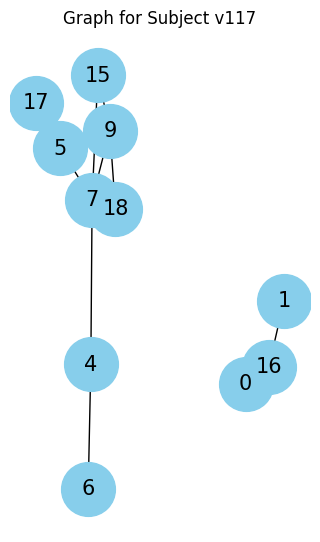

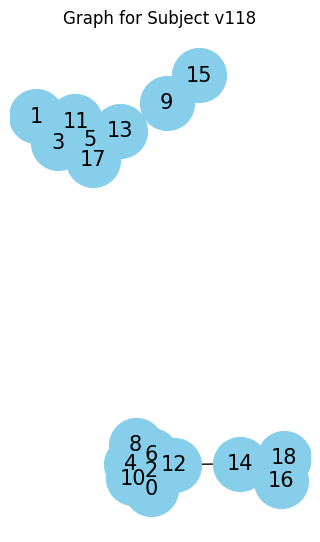

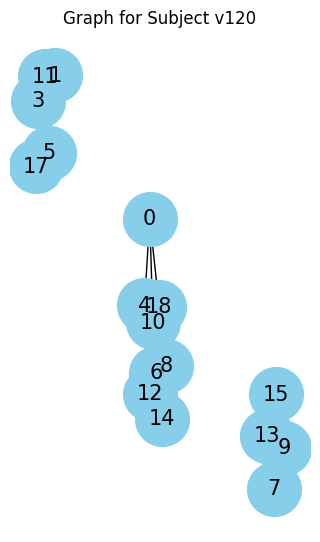

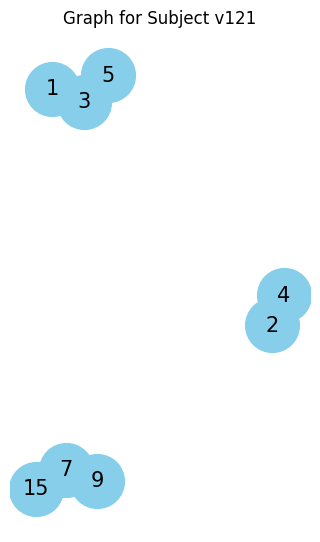

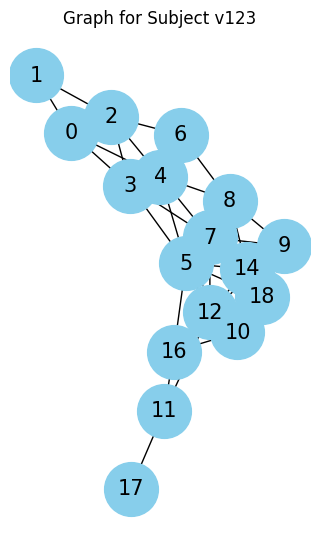

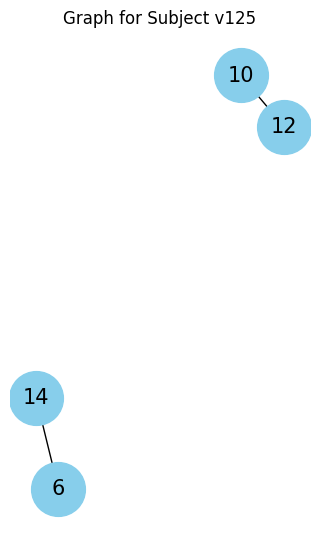

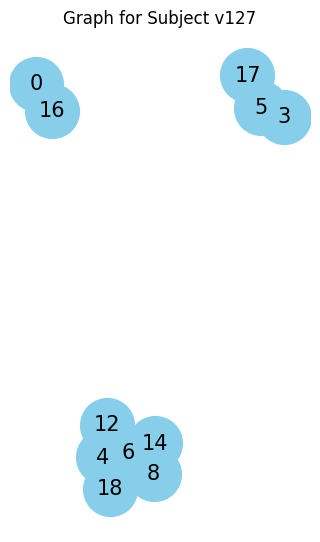

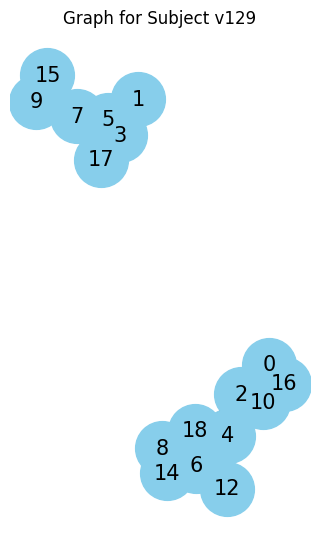

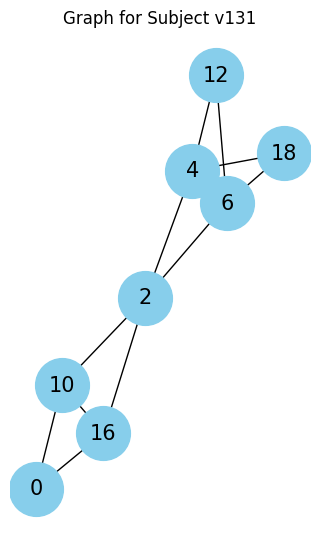

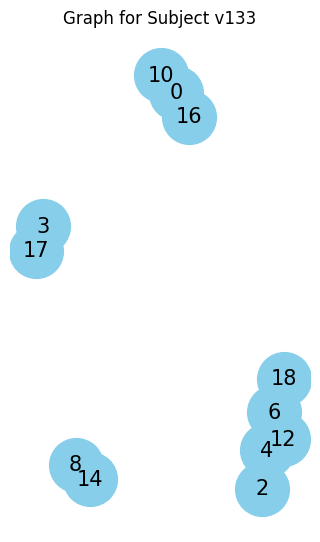

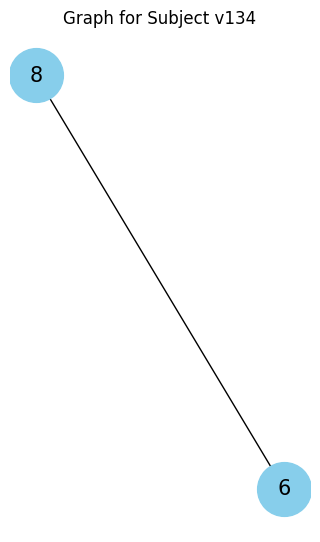

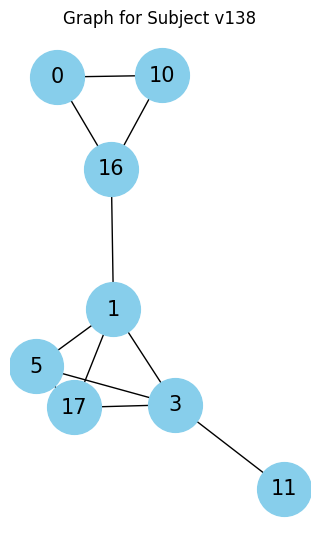

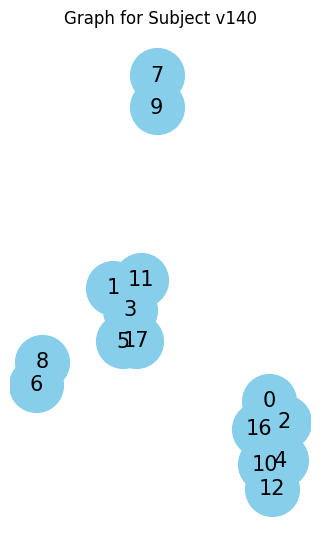

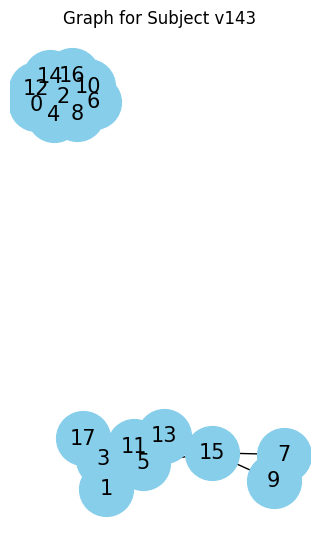

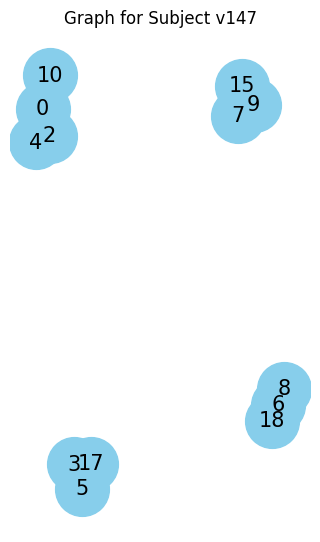

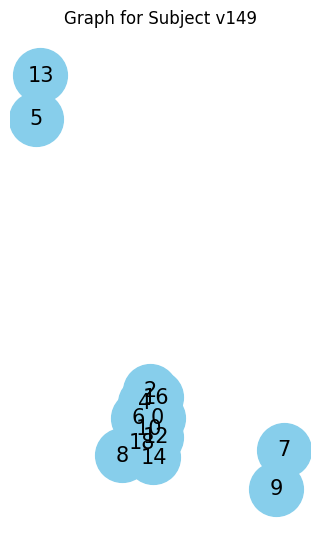

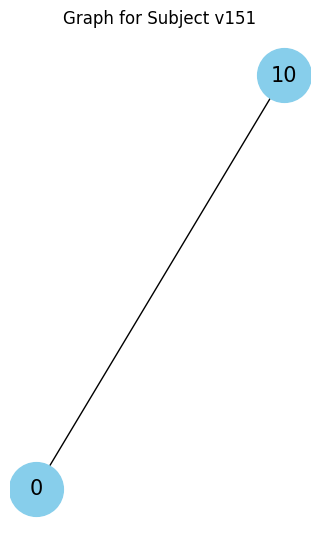

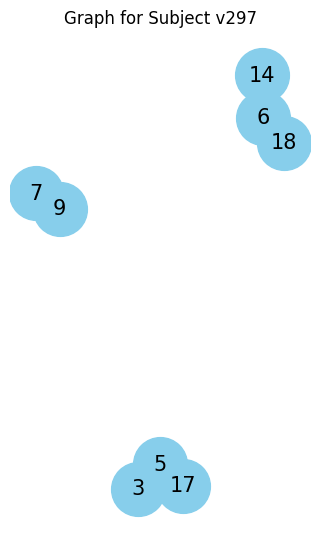

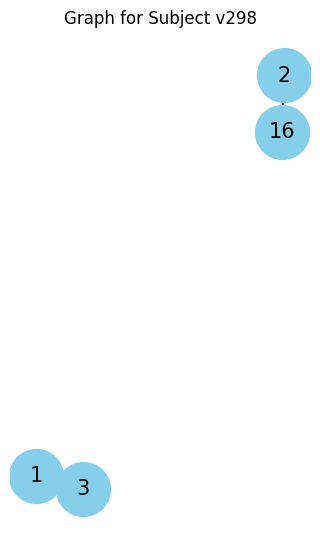

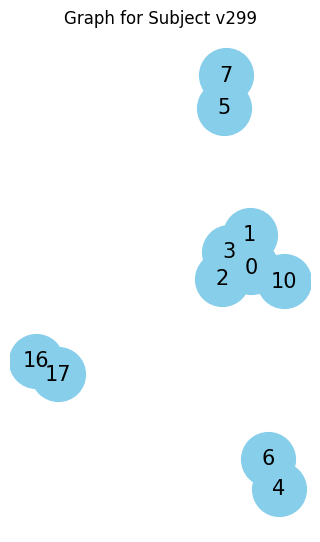

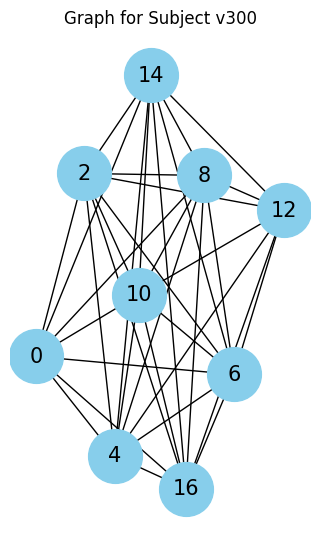

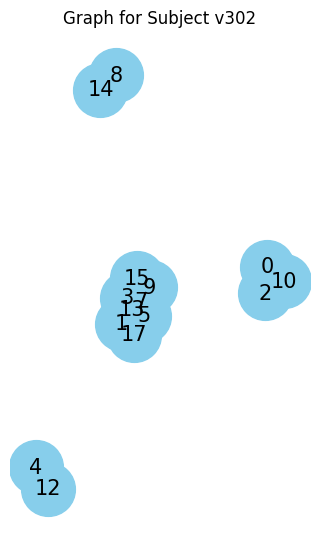

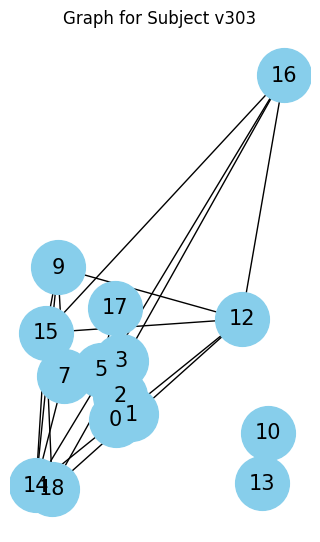

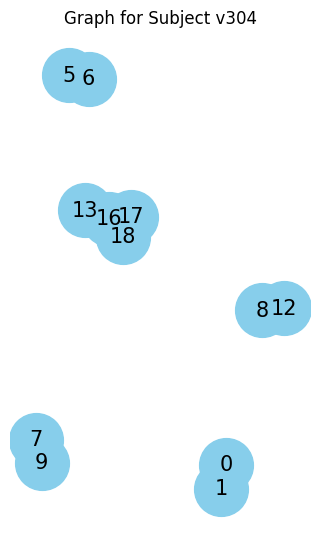

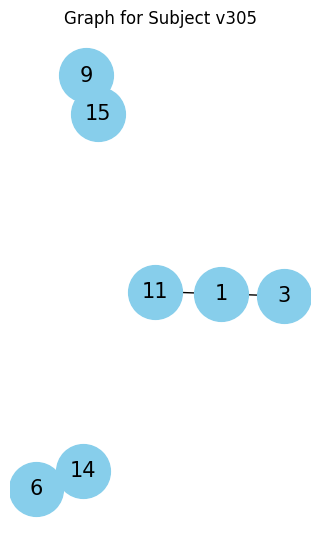

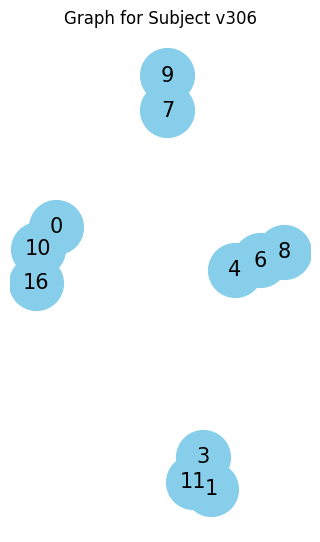

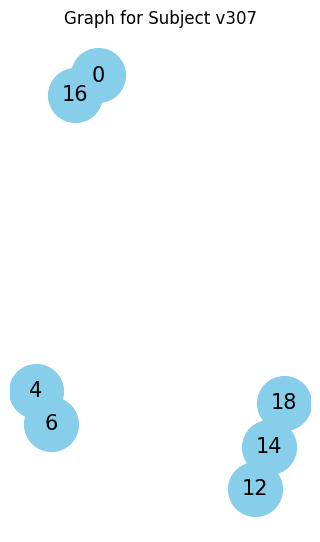

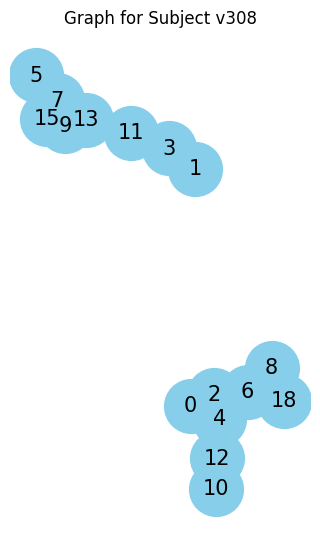

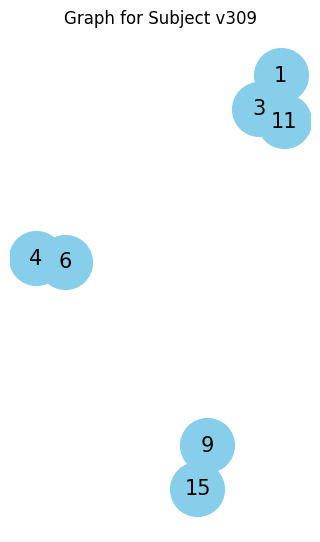

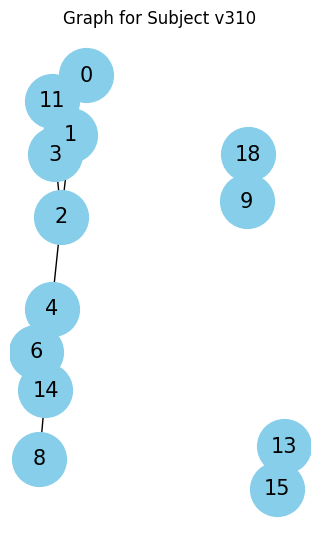

In [67]:
import matplotlib.pyplot as plt
import networkx as nx

graph_each_sub = []

for subject, corr_matrix in correlation_matrices.items():

    correlation_matrix = correlation_matrices[subject]
    G = form_graph(correlation_matrix, threshold=0.8)
    graph_each_sub.append(G)

    pos = nx.spring_layout(G) 
   
    plt.figure(figsize=(3,5))

    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='black', linewidths=1, font_size=15)
    plt.title(f"Graph for Subject {subject}")

    plt.show()


In [68]:
# Find centrality measure for all the nodes in a graph

def find_centrality_measures(graph):

    # Calculate centrality measures
    degree_centrality = nx.degree_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)

    return degree_centrality, closeness_centrality, betweenness_centrality


In [69]:
all_features = []

for graph in graph_each_sub:
    deg, close, bet = find_centrality_measures(graph)

    deg_list = list(deg.values())
    close_list = list(close.values())
    bet_list = list(bet.values())

    # Combine the deg, close and bet cents of all the nodes
    features = np.column_stack((deg_list, close_list, bet_list))
    #print(features)

    # Extracting feature for training
    # Find the aggregate of the deg, close and bet cent of all the nodes
    aggregated_centrality = np.mean(features, axis=0)
    #print(aggregated_centrality)

    all_features.append(aggregated_centrality)

print(all_features)

[array([0.2       , 0.30524271, 0.06060606]), array([0.23529412, 0.27760932, 0.02369281]), array([0.27205882, 0.28469808, 0.00343137]), array([0.17857143, 0.20238095, 0.01190476]), array([0.32352941, 0.48139494, 0.07843137]), array([0.33333333, 0.33333333, 0.        ]), array([0.2       , 0.2521645 , 0.01616162]), array([0.22058824, 0.28996116, 0.02352941]), array([0.42857143, 0.5391924 , 0.1547619 ]), array([0.13636364, 0.16464646, 0.01060606]), array([1., 1., 0.]), array([0.39285714, 0.51950101, 0.16666667]), array([0.13333333, 0.17549131, 0.01025641]), array([0.35294118, 0.38214816, 0.00980392]), array([0.16666667, 0.175     , 0.002331  ]), array([0.42857143, 0.45124251, 0.00732601]), array([1., 1., 0.]), array([0.17857143, 0.20238095, 0.01190476]), array([0.33333333, 0.33333333, 0.        ]), array([0.16363636, 0.18926407, 0.00808081]), array([0.97222222, 0.97530864, 0.00396825]), array([0.27619048, 0.28465608, 0.0029304 ]), array([0.26666667, 0.33248001, 0.07765568]), array([0.121

In [70]:
file_name = r'D:\sanjay\sem 6\ADHD\one_hot_encoded_keywords.csv'

with open(file_name, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for array in all_features:
        writer.writerow(array)


In [72]:
data = pd.read_csv('C:/Users/Bala/Downloads/ADHD_dataset.csv')

In [73]:
data.head()

,Degree_Centrality,Closeness_Centrality,Betweeness_Centrality,ADHD_Class
0,0.500000,0.500000,0.000000,1
1,0.133333,0.200607,0.027778,1
2,0.072727,0.079545,0.004040,1
3,0.233333,0.311523,0.083333,1
4,0.166667,0.166667,0.000000,1


In [74]:
X = data[['Degree_Centrality', 'Closeness_Centrality', 'Betweeness_Centrality']].values
y = data['ADHD_Class'].values

In [75]:
X

array([[5.00000000e-01, 5.00000000e-01, 0.00000000e+00],
       [1.33333334e-01, 2.00607194e-01, 2.77777780e-02],
       [7.27272725e-02, 7.95454545e-02, 4.04040400e-03],
       [2.33333333e-01, 3.11522968e-01, 8.33333335e-02],
       [1.66666667e-01, 1.66666667e-01, 0.00000000e+00],
       [9.61538460e-02, 1.51284812e-01, 1.11305362e-01],
       [9.61538460e-02, 1.23214286e-01, 8.74125850e-03],
       [1.66666667e-01, 1.66666667e-01, 0.00000000e+00],
       [1.42857143e-01, 1.62641724e-01, 2.08333335e-02],
       [9.52380950e-02, 1.03174603e-01, 4.76190500e-03],
       [1.22222222e-01, 2.13043868e-01, 9.02777780e-02],
       [1.21212121e-01, 1.55235799e-01, 1.36363635e-02],
       [1.60130719e-01, 1.73555298e-01, 9.19117650e-03],
       [6.66666665e-02, 7.40740740e-02, 2.77777800e-03],
       [8.33333335e-02, 1.16931925e-01, 2.57575760e-02],
       [2.19780220e-01, 2.28124257e-01, 2.74725250e-03],
       [1.66666667e-01, 2.51400560e-01, 1.09523809e-01],
       [1.08333334e-01, 1.33557

In [76]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

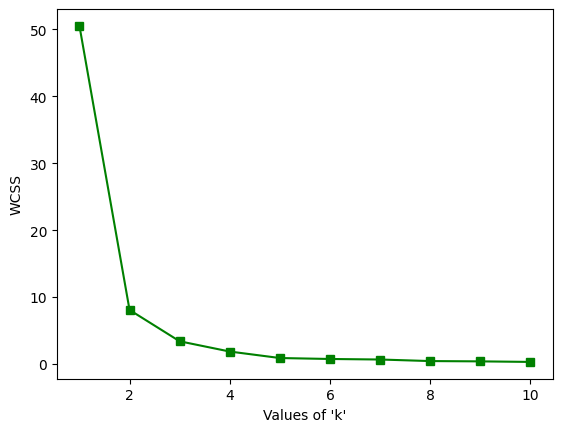

In [78]:
from sklearn.cluster import KMeans
wcss = {} 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    wcss[i] = kmeans.inertia_
     
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel("Values of 'k'")
plt.ylabel('WCSS')
plt.show()

In [79]:
kmeans=KMeans(n_clusters=2)
kmeans.fit(X)

KMeans(n_clusters=2)

In [80]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
 
reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

reduced_X.head()

,PCA1,PCA2
0,-0.294298,-0.409774
1,-0.589047,-0.040649
2,-0.690917,0.039713
3,-0.448534,-0.114873
4,-0.608447,-0.058370


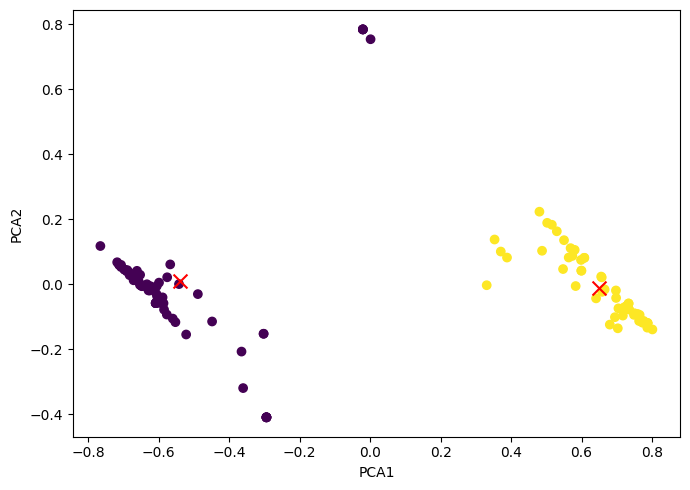

In [81]:
centers=pca.transform(kmeans.cluster_centers_)
plt.figure(figsize=(7,5))
plt.scatter(reduced_X['PCA1'],reduced_X['PCA2'],c=kmeans.labels_)
plt.scatter(centers[:,0],centers[:,1],marker='x',s=100,c='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.tight_layout()

In [92]:
from sklearn.metrics import silhouette_samples , silhouette_score
print(f'Silhouette Score(n=2): {silhouette_score(X, y)}')

Silhouette Score(n=2): 0.7823898750633292


In [84]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
# Predicting the clusters on new data (X_test)
predictions = kmeans.predict(X_test)
# Calculate the confusion matrix using true labels and predictions
cm = confusion_matrix(y_test, predictions, labels=[0, 1])
print(cm)

[[ 2 16]
 [19  0]]


In [85]:
from sklearn.metrics import precision_score
precision_score(y_test, predictions,average='micro')

0.05405405405405406

In [86]:
from sklearn.metrics import recall_score
recall_score(y_test, predictions,average='micro')

0.05405405405405406

In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions,labels=[0,1],target_names=['Non_ADHD', 'ADHD']))


              precision    recall  f1-score   support

    Non_ADHD       0.10      0.11      0.10        18
        ADHD       0.00      0.00      0.00        19

    accuracy                           0.05        37
   macro avg       0.05      0.06      0.05        37
weighted avg       0.05      0.05      0.05        37



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions,labels=[0,1],target_names=['Diabetic', 'Non_Diabetic']))

In [ ]:
svm_classifier = SVC(kernel='poly', C=0.01, gamma='scale')

svm_classifier.fit(X_train, y_train)

SVC(C=0.01, kernel='poly')

In [ ]:
y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9459459459459459
